In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Introduction

Here I will test saving models :
- Save and load a model
- Save and load coss-validated models
- Save and load multiple experiment

# Pizza toy dataset

In [2]:
import datawarehouse as dw

In [3]:
X, y = dw.make_pizza_slice(n_samples=1000, end_angle=np.pi)

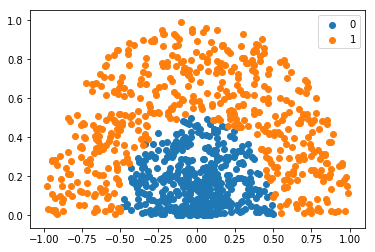

In [4]:

plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.legend()
plt.show()


# Skewing

In [5]:
def skew(X, z):
    x = X[:, 0]
    y = X[:, 1]
    theta = np.arctan2(y, x) + z
    r = np.sqrt(x*x + y*y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X_skew = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    return X_skew

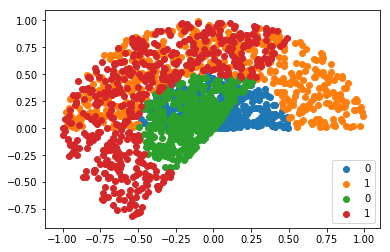

In [6]:
X_skew = skew(X, 45)
plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.scatter(X_skew[y==0, 0], X_skew[y==0, 1], label='0')
plt.scatter(X_skew[y==1, 0], X_skew[y==1, 1], label='1')
plt.legend()
plt.show()


# Cross validation

In [7]:
from sklearn.model_selection import ShuffleSplit
RANDOM_STATE = 0

def get_cv_iter(X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
    cv_iter = list(cv.split(X, y))
    return cv_iter


In [8]:
cv_0 = get_cv_iter(X, y)
cv_1 = get_cv_iter(X, y)
cv_2 = get_cv_iter(np.ones_like(X), np.zeros_like(y))

In [9]:
for e0, e1, e2 in zip(cv_0, cv_1, cv_2):
    train_idx_0, test_idx_0 = e0
    train_idx_1, test_idx_1 = e1
    train_idx_2, test_idx_2 = e2
    assert( np.alltrue(train_idx_0 == train_idx_1) ) 
    assert( np.alltrue(test_idx_0 == test_idx_1) )
    print(train_idx_0[0])
    

687
777
536
201
164


# Submission

## Train submission

In [28]:
SAVE_DIR = '/home/estrade/Bureau/PhD/SystML/savings'

In [10]:
from problem.workflow import check_dir
from problem.workflow import print as pprint

def get_save_directory():
    return '/home/estrade/Bureau/PhD/SystML/savings/pizza'


In [11]:
def train_submission(model, X, y):
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    save_directory = get_save_directory()
    for i, (train_idx, test_idx) in enumerate(cv_iter):
        X_train = X[train_idx]
        y_train = y[train_idx]
        
#         pprint('training {}/{}...'.format(i+1, n_cv))
        model.fit(X_train, y_train)

#         pprint('saving model {}/{}...'.format(i+1, n_cv))
        model_name = '{}-{}'.format(model.get_name(), i)
        
        path = os.path.join(save_directory, model_name)
        check_dir(path)
        
        model.save(path)

        X_test = X[test_idx]
        y_test = y[test_idx]
        proba = model.predict_proba(X_test)
        print('score', model.score(X_test, y_test) )
        print('x', X_test[0])
        print('y', y_test[0])
        print('proba', proba[0], proba[-1])
    return None


## Load submission 

In [12]:
def load_models(model_class, *args, **kwargs):
    models = []
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    for i in range(n_cv):
        model = model_class(*args, **kwargs)
        save_directory = get_save_directory()
        model_name = '{}-{}'.format(model.get_name(), i)
        path = os.path.join(save_directory, model_name)
        model.load(path)
        models.append(model)
    return models

## Test submission

In [13]:
def test_submission(model_class, X, y, *args, **kwargs):
    models = load_models(model_class, *args, **kwargs)
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    for m, (train_idx, test_idx) in zip(models, cv_iter):
        X_test = X[test_idx]
        y_test = y[test_idx]
        proba = m.predict_proba(X_test)
        print('score', m.score(X_test, y_test) )
        print('x', X_test[0])
        print('y', y_test[0])
        print('proba', proba[0], proba[-1])


# Neural Net

In [14]:
from models.pizza import NeuralNetModel


In [16]:
model = NeuralNetModel()
model.fit(X, y)
model.save(SAVE_DIR)
proba_0 = model.predict_proba(X)


In [17]:
model = NeuralNetModel(n_steps=1)
proba_2 = model.fit(X, y)
model.load(SAVE_DIR)
proba_1 = model.predict_proba(X)


In [18]:
assert( np.alltrue(proba_0 == proba_1) )
print('OK')

OK


In [19]:
proba_0 == proba_2

array([[False, False],
       [False, False],
       [False, False],
       ..., 
       [False, False],
       [False, False],
       [False, False]], dtype=bool)

In [20]:
model = NeuralNetModel()
train_submission(model, X, y)

score 0.96
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.7788102   0.22118983] [ 0.9872486   0.01275139]
score 0.99
x [-0.59445698  0.35952144]
y 1.0
proba [  2.82225028e-06   9.99997199e-01] [ 0.99184728  0.00815271]
score 0.985
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.88149548  0.11850451] [  9.99979854e-01   2.01493422e-05]
score 0.98
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.00985817  0.99014181] [ 0.64297336  0.35702667]
score 1.0
x [ 0.18378018  0.77325951]
y 1.0
proba [  1.06004379e-10   1.00000000e+00] [ 0.98669934  0.01330063]


In [21]:
test_submission(NeuralNetModel, X, y)

score 0.96
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.7788102   0.22118983] [ 0.9872486   0.01275139]
score 0.99
x [-0.59445698  0.35952144]
y 1.0
proba [  2.82225028e-06   9.99997199e-01] [ 0.99184728  0.00815271]
score 0.985
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.88149548  0.11850451] [  9.99979854e-01   2.01493422e-05]
score 0.98
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.00985817  0.99014181] [ 0.64297336  0.35702667]
score 1.0
x [ 0.18378018  0.77325951]
y 1.0
proba [  1.06004379e-10   1.00000000e+00] [ 0.98669934  0.01330063]


In [22]:
list(model.net.fc3.parameters())

[Parameter containing:
 -1.7668  0.0588  0.0788  0.1553 -2.0428
  1.8298 -0.2235  0.2580 -0.3332  2.1294
 [torch.FloatTensor of size 2x5], Parameter containing:
  2.1194
 -2.2262
 [torch.FloatTensor of size 2]]

In [23]:
models = load_models(NeuralNetModel)

In [24]:
list(models[-1].net.fc3.parameters())

[Parameter containing:
 -1.7668  0.0588  0.0788  0.1553 -2.0428
  1.8298 -0.2235  0.2580 -0.3332  2.1294
 [torch.FloatTensor of size 2x5], Parameter containing:
  2.1194
 -2.2262
 [torch.FloatTensor of size 2]]

In [25]:
print( model.scaler.mean_, model.scaler.scale_)

[ 0.02406014  0.30777288] [ 0.42089949  0.25297305]


In [26]:
print( models[-1].scaler.mean_, models[-1].scaler.scale_)

[ 0.02406014  0.30777288] [ 0.42089949  0.25297305]


# Augmented Neural Net

In [27]:
from models.pizza import AugmentedNeuralNetModel


In [29]:
model = AugmentedNeuralNetModel(skew)
model.fit(X, y)
model.save(SAVE_DIR)
proba_0 = model.predict_proba(X)


In [30]:
model = AugmentedNeuralNetModel(skew)
model.load(SAVE_DIR)
proba_1 = model.predict_proba(X)


In [31]:
assert( np.alltrue(proba_0 == proba_1) )
print('OK')

OK


In [32]:
train_submission(model, X, y)

score 0.99
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.61104828  0.38895169] [ 0.98193675  0.01806323]
score 0.995
x [-0.59445698  0.35952144]
y 1.0
proba [  3.38264043e-04   9.99661744e-01] [  9.99947369e-01   5.26357071e-05]
score 0.475
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.49456015  0.50543982] [ 0.49456015  0.50543982]
score 0.98
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.0019764   0.99802363] [ 0.79784518  0.20215484]
score 0.985
x [ 0.18378018  0.77325951]
y 1.0
proba [  3.17693730e-06   9.99996841e-01] [ 0.91490787  0.08509214]


In [33]:
test_submission(AugmentedNeuralNetModel, X, y, skew)

score 0.99
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.61104828  0.38895169] [ 0.98193675  0.01806323]
score 0.995
x [-0.59445698  0.35952144]
y 1.0
proba [  3.38264043e-04   9.99661744e-01] [  9.99947369e-01   5.26357071e-05]
score 0.475
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.49456015  0.50543982] [ 0.49456015  0.50543982]
score 0.98
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.0019764   0.99802363] [ 0.79784518  0.20215484]
score 0.985
x [ 0.18378018  0.77325951]
y 1.0
proba [  3.17693730e-06   9.99996841e-01] [ 0.91490787  0.08509214]


# Tangent Prop

In [34]:
from models.pizza import TangentPropModel


In [35]:
model = TangentPropModel(skew)
model.fit(X, y)
model.save(SAVE_DIR)
proba_0 = model.predict_proba(X)


In [36]:
model = TangentPropModel(skew)
model.load(SAVE_DIR)
proba_1 = model.predict_proba(X)


In [37]:
assert( np.alltrue(proba_0 == proba_1) )
print('OK')

OK


In [38]:
train_submission(model, X, y)

score 0.98
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.8107869  0.1892131] [  9.99728799e-01   2.71191326e-04]
score 0.965
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.03626968  0.96373034] [ 0.99832273  0.0016773 ]
score 0.975
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.82624662  0.17375338] [ 0.99877977  0.00122024]
score 0.97
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.19031253  0.80968744] [ 0.50947279  0.49052724]
score 0.96
x [ 0.18378018  0.77325951]
y 1.0
proba [  2.21738577e-04   9.99778271e-01] [ 0.98576069  0.01423933]


In [39]:
test_submission(TangentPropModel, X, y, skew)

score 0.98
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.8107869  0.1892131] [  9.99728799e-01   2.71191326e-04]
score 0.965
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.03626968  0.96373034] [ 0.99832273  0.0016773 ]
score 0.975
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.82624662  0.17375338] [ 0.99877977  0.00122024]
score 0.97
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.19031253  0.80968744] [ 0.50947279  0.49052724]
score 0.96
x [ 0.18378018  0.77325951]
y 1.0
proba [  2.21738577e-04   9.99778271e-01] [ 0.98576069  0.01423933]


# Augmented Tangent Prop

In [40]:
from models.pizza import AugmentedTangentPropModel


In [41]:
model = AugmentedTangentPropModel(skew)
model.fit(X, y)
model.save(SAVE_DIR)
proba_0 = model.predict_proba(X)


In [42]:
model = AugmentedTangentPropModel(skew)
model.load(SAVE_DIR)
proba_1 = model.predict_proba(X)


In [43]:
assert( np.alltrue(proba_0 == proba_1) )
print('OK')

OK


In [44]:
train_submission(model, X, y)

score 0.99
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.70883644  0.29116359] [  9.99488592e-01   5.11413848e-04]
score 0.97
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.19127963  0.80872035] [ 0.85451412  0.14548586]
score 0.945
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.65065044  0.34934956] [ 0.87620175  0.12379825]
score 0.975
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.12048316  0.87951684] [ 0.67682368  0.32317632]
score 0.98
x [ 0.18378018  0.77325951]
y 1.0
proba [  5.17272973e-04   9.99482751e-01] [ 0.96006495  0.03993504]


In [45]:
test_submission(AugmentedTangentPropModel, X, y, skew)

score 0.99
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.70883644  0.29116359] [  9.99488592e-01   5.11413848e-04]
score 0.97
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.19127963  0.80872035] [ 0.85451412  0.14548586]
score 0.945
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.65065044  0.34934956] [ 0.87620175  0.12379825]
score 0.975
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.12048316  0.87951684] [ 0.67682368  0.32317632]
score 0.98
x [ 0.18378018  0.77325951]
y 1.0
proba [  5.17272973e-04   9.99482751e-01] [ 0.96006495  0.03993504]


# Pivot

In [46]:
from models.pizza import PivotModel


In [48]:
model = PivotModel()
model.fit(X, y)
model.save(SAVE_DIR)
proba_0 = model.predict_proba(X)


In [49]:
model = PivotModel()
model.load(SAVE_DIR)
proba_1 = model.predict_proba(X)


In [50]:
assert( np.alltrue(proba_0 == proba_1) )
print('OK')

OK


In [51]:
train_submission(model, X, y)

score 0.85
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.82952273  0.17047724] [ 0.93611467  0.06388534]
score 0.805
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.1377001   0.86229992] [ 0.66065186  0.33934817]
score 0.99
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.90138149  0.09861849] [ 0.99882364  0.00117636]
score 0.95
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.21987684  0.78012317] [ 0.57066911  0.42933086]
score 0.97
x [ 0.18378018  0.77325951]
y 1.0
proba [  7.23098521e-04   9.99276876e-01] [ 0.85888165  0.14111838]


In [52]:
test_submission(PivotModel, X, y)

score 0.85
x [-0.48859101  0.04413622]
y 0.0
proba [ 0.82952273  0.17047724] [ 0.93611467  0.06388534]
score 0.805
x [-0.59445698  0.35952144]
y 1.0
proba [ 0.1377001   0.86229992] [ 0.66065186  0.33934817]
score 0.99
x [ 0.47428625  0.01127291]
y 0.0
proba [ 0.90138149  0.09861849] [ 0.99882364  0.00117636]
score 0.95
x [ 0.59186013  0.1849403 ]
y 1.0
proba [ 0.21987684  0.78012317] [ 0.57066911  0.42933086]
score 0.97
x [ 0.18378018  0.77325951]
y 1.0
proba [  7.23098521e-04   9.99276876e-01] [ 0.85888165  0.14111838]


# Augmented Pivot